# Step 1: Data Acquisition

The first step in this process is to retrieve the monthly user data from two public wikimedia apis, pagecounts and pageviews. We will then save each of the responses to their own .json file.

In [1]:
import json
import requests

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Define some helper functions to read and write data

In [3]:
headers = {
    'User-Agent': 'https://github.com/kevSweet',
    'From': 'ksweet1@uw.edu'
}

# dump dictionary to file
def write_to_json(data, fn):
    with open(fn, "w") as outfile:
        json.dump(data, outfile)

def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

The legacy endpoint (pagecounts) contains two different access types, desktop and mobile. We want data on both types, so we will make two separate requests for them.

In [4]:
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# pagecounts dump

# desktop
monthly_legacy = api_call(endpoint_legacy, params_legacy)
first_date = monthly_legacy['items'][0]['timestamp']
last_date = monthly_legacy['items'][-1]['timestamp']
legacy_desktopfn = 'pagecounts_desktop-site_' + first_date + '-' + last_date + '.json'
write_to_json(monthly_legacy, legacy_desktopfn)

# mobile
params_legacy['access-site'] = "mobile-site"
monthly_legacy = api_call(endpoint_legacy, params_legacy)
first_date = monthly_legacy['items'][0]['timestamp']
last_date = monthly_legacy['items'][-1]['timestamp']
legacy_mobilefn = 'pagecounts_mobile-site_' + first_date + '-' + last_date + '.json'
write_to_json(monthly_legacy, legacy_mobilefn)

The pageview endpoint further delineates mobile into mobile app and mobile web, so we will need to make an additional request for that data.

In [5]:
# define parameters for api call
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021110100'
                        }

# pageviews dump

# retrieve & reformat desktop data
monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
first_date = monthly_pageviews['items'][0]['timestamp']
last_date = monthly_pageviews['items'][-1]['timestamp']
pageviews_desktopfn = 'pageviews_desktop-site_'+ first_date + '-' + last_date + '.json'
write_to_json(monthly_pageviews, pageviews_desktopfn)

# retrieve & reformat mobile app data
params_pageviews['access'] = "mobile-app"
monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
first_date = monthly_pageviews['items'][0]['timestamp']
last_date = monthly_pageviews['items'][-1]['timestamp']
pageviews_mobileappfn = 'pageviews_mobile-app_'+ first_date + '-' + last_date + '.json'
write_to_json(monthly_pageviews, pageviews_mobileappfn)

# retrieve & reformat mobile web data
params_pageviews['access'] = "mobile-web"
monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
first_date = monthly_pageviews['items'][0]['timestamp']
last_date = monthly_pageviews['items'][-1]['timestamp']
pageviews_mobilewebfn = 'pageviews_mobile-web_'+ first_date + '-' + last_date + '.json'
write_to_json(monthly_pageviews, pageviews_mobilewebfn)

# Step 2: Data Processing

Now that we have retrieved the data, we want to merge and format it so we can later analyze how the user counts have changed over time.

In [6]:
import pandas as pd
import datetime

Helper functions for transforming data

In [7]:
def convert_dates(items_dict):
    for item in items_dict:
        datee = datetime.datetime.strptime(item['timestamp'], "%Y%m%d%H")
        item['year'] = datee.year
        item['month'] = datee.strftime("%m")
        del(item['timestamp'])
    return pd.DataFrame(items_dict)

def tabularize_data(items_dict, api):
    items_dict = convert_dates(items_dict)
    items_dict_tabularized = pd.json_normalize(items_dict['items'])
    if api == 'pagecounts':
        items_dict_tabularized = items_dict_tabularized.drop(['project', 'access-site', 'granularity'], axis=1)
    elif api == 'pageviews':
        items_dict_tabularized = items_dict_tabularized.drop(['project', 'access', 'granularity', 'agent'], axis=1)
    else:
        raise Exception('please enter valid api (pagecounts or pageviews)')
        
    return items_dict_tabularized

In [8]:
# Desktop Pagecounts
pagecounts_desktop = pd.read_json('./pagecounts_desktop-site_2007120100-2016080100.json')
pagecounts_desktop_tabular = tabularize_data(pagecounts_desktop['items'], 'pagecounts')
pagecounts_desktop_tabular

,count,year,month
0,2998331524,2007,12
1,4930902570,2008,01
2,4818393763,2008,02
3,4955405809,2008,03
4,5159162183,2008,04
...,...,...,...
100,5572235399,2016,04
101,5330532334,2016,05
102,4975092447,2016,06
103,5363966439,2016,07


In [9]:
# Mobile Pagecounts
pagecounts_mobile = pd.read_json('./pagecounts_mobile-site_2014100100-2016080100.json')
pagecounts_mobile_tabular = tabularize_data(pagecounts_mobile['items'], 'pagecounts')
pagecounts_mobile_tabular

,count,year,month
0,3091546685,2014,10
1,3027489668,2014,11
2,3278950021,2014,12
3,3485302091,2015,01
4,3091534479,2015,02
5,3330832588,2015,03
6,3222089917,2015,04
7,3334069483,2015,05
8,3038162463,2015,06
9,3254472695,2015,07


In [10]:
# Desktop Pageviews
pageviews_desktop = pd.read_json('./pageviews_desktop-site_2015070100-2021090100.json')
pageviews_desktop_tabular = tabularize_data(pageviews_desktop['items'], 'pageviews')
pageviews_desktop_tabular

,views,year,month
0,4376666686,2015,07
1,4332482183,2015,08
2,4485491704,2015,09
3,4477532755,2015,10
4,4287720220,2015,11
...,...,...,...
70,2824416177,2021,05
71,2505971366,2021,06
72,2765584368,2021,07
73,2763413934,2021,08


In [11]:
# Mobile Pageviews
pageviews_mobileweb = pd.read_json('./pageviews_mobile-web_2015070100-2021090100.json')
pageviews_mobileapp = pd.read_json('./pageviews_mobile-app_2015070100-2021090100.json')
pageviews_mobile = pageviews_mobileweb.append(pageviews_mobileapp, ignore_index=True)

pageviews_mobile_tabular = tabularize_data(pageviews_mobile['items'], 'pageviews')
pageviews_mobile_tabular = pd.DataFrame(pageviews_mobile_tabular.groupby(['year', 'month']).views.agg(sum))
pageviews_mobile_tabular

views
year month            
2015 07     3288755294
     08     3302333038
     09     3170203333
     10     3268499132
     11     3236601070
...                ...
2021 05     4976579558
     06     4584510417
     07     4778909421
     08     4732194000
     09     4373512692

[75 rows x 1 columns]

Here we merge the data and perform final transformation 

In [16]:
merged = pd.merge(pagecounts_desktop_tabular, pagecounts_mobile_tabular, on=['year', 'month'], how='outer')
merged = pd.merge(merged, pageviews_desktop_tabular, on=['year', 'month'], how='outer')
merged = pd.merge(merged, pageviews_mobile_tabular, on=['year', 'month'], how='outer')
merged

,count_x,year,month,count_y,views_x,views_y
0,2.998332e+09,2007,12,NaN,NaN,NaN
1,4.930903e+09,2008,01,NaN,NaN,NaN
2,4.818394e+09,2008,02,NaN,NaN,NaN
3,4.955406e+09,2008,03,NaN,NaN,NaN
4,5.159162e+09,2008,04,NaN,NaN,NaN
...,...,...,...,...,...,...
161,NaN,2021,05,NaN,2.824416e+09,4.976580e+09
162,NaN,2021,06,NaN,2.505971e+09,4.584510e+09
163,NaN,2021,07,NaN,2.765584e+09,4.778909e+09
164,NaN,2021,08,NaN,2.763414e+09,4.732194e+09


In [24]:
merged = merged.rename(columns={"count_x": "pagecount_desktop_views", "count_y": "pagecount_mobile_views", 
                                "views_x": "pageview_desktop_views", "views_y": "pageview_mobile_views"})
merged = merged.fillna(0)
merged['pagecount_all_views'] = merged['pagecount_desktop_views'] + merged['pagecount_mobile_views']
merged['pageview_all_views'] = merged['pageview_desktop_views'] + merged['pageview_mobile_views']
merged = merged.reindex(columns=["year", "month", "pagecount_all_views", "pagecount_desktop_views",
                                 "pagecount_mobile_views", "pageview_all_views", "pageview_desktop_views",
                                 "pageview_mobile_views"])
merged

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
161,2021,05,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,06,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,07,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,08,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


In [27]:
wikitraffic_fn = 'en-wikipedia_traffic_200712-202108.csv'
merged.to_csv(wikitraffic_fn, index=False)

# Step 3: Analysis

Now that we have the data, we want to see how the number of users from the three different user types have changed over time.

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

To plot the x axis properly, we need a series of date objects. I create a new date field for this purpose. I then merge the pagecount and page view columns for mobile, desktop, and total into three new columns.

In [117]:
df = pd.read_csv('./' + wikitraffic_fn)
df['date'] = df['month'].map(str)+ '-' +df['year'].map(str)
df['date'] = pd.to_datetime(df['date'], format='%m-%Y')
df['all_views'] = df['pagecount_all_views'] + df['pageview_all_views'] 
df['desktop_views'] = df['pagecount_desktop_views'] + df['pageview_desktop_views']
df['mobile_views'] = df['pagecount_mobile_views'] + df['pageview_mobile_views']
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,date,all_views,desktop_views,mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-01,2.998332e+09,2.998332e+09,0.000000e+00
1,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008-01-01,4.930903e+09,4.930903e+09,0.000000e+00
2,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008-02-01,4.818394e+09,4.818394e+09,0.000000e+00
3,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008-03-01,4.955406e+09,4.955406e+09,0.000000e+00
4,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008-04-01,5.159162e+09,5.159162e+09,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021,5,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09,2021-05-01,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,6,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09,2021-06-01,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,7,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09,2021-07-01,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,8,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09,2021-08-01,7.495608e+09,2.763414e+09,4.732194e+09


Here we configure the matplotlib visualization

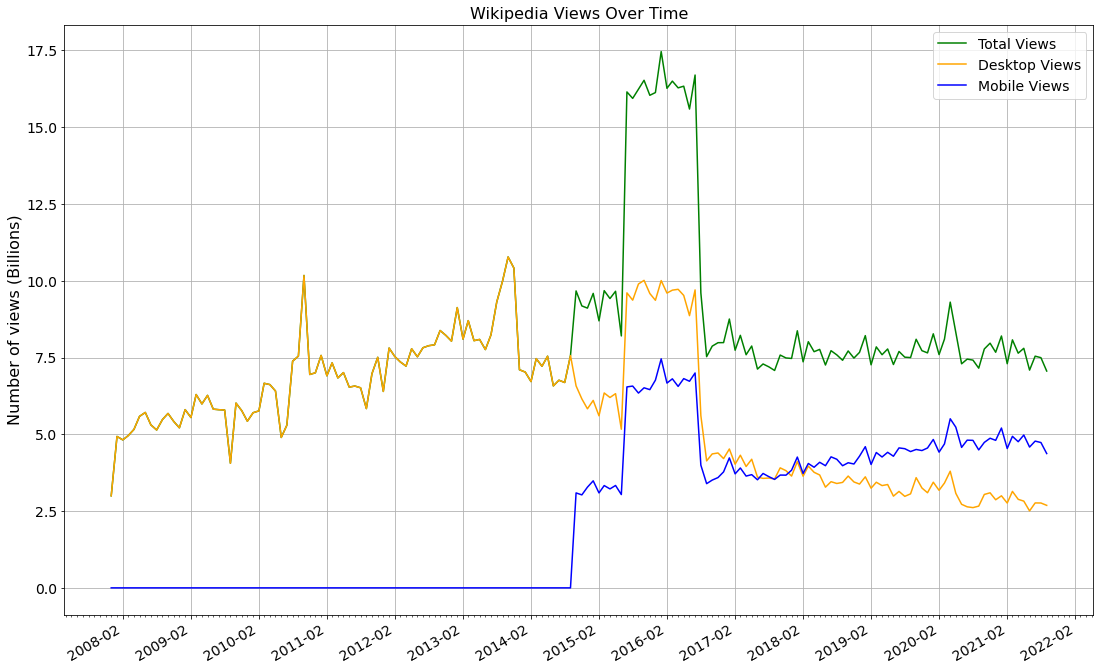

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

# format views to be in units of billions of views
ax.plot_date(df['date'], df['all_views']/1000000000, 'b-', label = 'Total Views', color='green')
ax.plot_date(df['date'], df['desktop_views']/1000000000, 'b-', label = 'Desktop Views', color = 'orange')
ax.plot_date(df['date'], df['mobile_views']/1000000000, 'b-', label = 'Mobile Views', color= 'blue')

# define interval for x axis major and minor ticks
fmt_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_year)

fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.grid(True)
fig.autofmt_xdate()
fig.tight_layout()

# adjust dimensions
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylabel('Number of views (Billions)', fontsize = 16)
plt.title('Wikipedia Views Over Time', fontsize = 16)

plt.savefig('final_graph.png', bbox_inches='tight')
plt.show()

As you can see from this graph, during the transition period between apis, there was roughly double the number of views for each platform. This continued until the legacy API was phased out in 2016.